In [2]:
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from plain_net.PlainNet import PlainNet
from soft_thresholding.SoftThresholdNet import SoftThresholdNet
from L1_regularization.L1RegularizationNet import L1RegularizationNet
from dynamic_sparse_reparameterization.DynamicSparseReparameterizationNet import DynamicSparseReparameterizationNet
from magnitude_pruning.MagnitudePruning import MagnitudePruningNet

from utils import load_data

/Users/emilhaugstvedt/mambaforge/envs/sparse/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
dataset = "alu" # alu or duffing
train_loader, test_loader, val_loader = load_data(f"data/{dataset}")
test_data = test_loader.dataset.y[0:4999]
t = torch.linspace(0, test_loader.dataset.DT, len(test_data))

In [4]:
y_test = test_loader.dataset.y[0:4999]
x_test = test_loader.dataset.x_non_norm[0:4999]

In [99]:
model_type = "magnitude_pruning" # plain, soft_thresholding, L1_regularization, dynamic_sparse_reparameterization, magnitude_pruning

models = []
for i in range(3):
    with open(f"models/alu/{model_type}/model_{i+1}.pickle", "rb") as f:
        state_dict = torch.load(f)
    model = MagnitudePruningNet(layers=[13, 64, 64, 64, 8])
    model.load_state_dict(state_dict)
    models.append(model)

In [100]:
y_hat = model(test_loader.dataset.x[0:4999])

In [101]:
predictions = []
for model in models:
    prediction = torch.zeros_like(x_test).detach()
    prediction[:, 8:] = x_test[:, 8:]
    prediction[0, :8] = x_test[0, :8]

    predictions.append(prediction.detach())

In [102]:
dt = test_loader.dataset.DT
y_std = test_loader.dataset.y_std
y_mean = test_loader.dataset.y_mean
x_std = test_loader.dataset.x_std
x_mean = test_loader.dataset.x_mean

for model, prediction in zip(models, predictions):
    for i in range(1, len(prediction)):
        input = (prediction[i-1] - x_mean) / x_std
        x_dot = model(input) * y_std + y_mean
        prediction[i, :8] = prediction[i-1, :8] + x_dot * dt

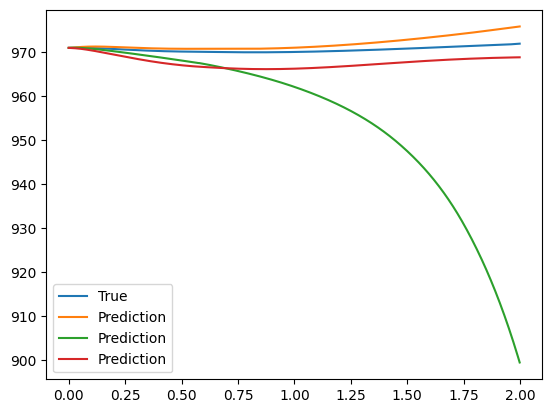

In [110]:
state = 5
steps = 1000

plt.plot(t[:steps], x_test[:steps, state], label="True")
for prediction in predictions:
    plt.plot(t[:steps], prediction[:steps, state].detach(), label="Prediction")
plt.legend()
plt.show()

In [10]:
mean_prediction = torch.zeros_like(x_test).detach()
for prediction in predictions:
    mean_prediction += prediction
mean_prediction /= len(predictions)